<a href="https://colab.research.google.com/github/ShepherdCode/ShepherdML/blob/master/Nasa2021/GRU_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRU 501
LSTM 403 modified to use GRU layers 

In [5]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
MODEL_FILE='GRU501'   # load not save!
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
NC_FILENAME = DATAPATH+NC_FILENAME
PC_FILENAME = DATAPATH+PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=100
SPLITS=1
K=3
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
NEURONS=16
DROP=0.4
ACT="tanh"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
# Load our own tools
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
#from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [8]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    embed_layer  = keras.layers.Embedding(
        #VOCABULARY_SIZE, EMBED_DIMEN, input_length=1000, input_length=1000, mask_zero=True)
        #input_dim=[None,VOCABULARY_SIZE], output_dim=EMBED_DIMEN, mask_zero=True)
        input_dim=VOCABULARY_SIZE, output_dim=EMBED_DIMEN, mask_zero=True)
    rnn1_layer = keras.layers.GRU(NEURONS, return_sequences=True, 
          input_shape=[1000,EMBED_DIMEN], activation=ACT, dropout=DROP)
    rnn2_layer = keras.layers.GRU(NEURONS, return_sequences=False, 
        activation=ACT, dropout=DROP)
    dense1_layer = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    drop1_layer = keras.layers.Dropout(DROP)
    dense2_layer = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    drop2_layer = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)
    mlp = keras.models.Sequential()
    mlp.add(embed_layer)
    mlp.add(rnn1_layer)
    mlp.add(rnn2_layer)
    mlp.add(dense1_layer)
    mlp.add(drop1_layer)
    mlp.add(dense2_layer)
    mlp.add(drop2_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

Partition sequences

In [9]:
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

Cross validation

In [10]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [11]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=tools.load_fasta(NC_FILENAME,0)
pc_seq=tools.load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=tools.make_kmers(K,MAXLEN,subset)
#print ("Data prep")
#X_train=tools.make_frequencies(K,X_train)

Load data from files.
Ready: train_set
Data reshape


In [12]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          1040      
_________________________________________________________________
gru (GRU)                    (None, None, 16)          1632      
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_____________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.model/assets


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/100
453/453 [==============================] - 39s 66ms/step - loss: 0.6542 - accuracy: 0.6365 - val_loss: 0.6043 - val_accuracy: 0.6723


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 2/100
453/453 [==============================] - 28s 62ms/step - loss: 0.6238 - accuracy: 0.6514 - val_loss: 0.6026 - val_accuracy: 0.6754


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 3/100
453/453 [==============================] - 29s 64ms/step - loss: 0.6386 - accuracy: 0.6509 - val_loss: 0.6142 - val_accuracy: 0.6629
Epoch 4/100
453/453 [==============================] - 28s 63ms/step - loss: 0.6287 - accuracy: 0.6528 - val_loss: 0.5898 - val_accuracy: 0.7008


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 5/100
453/453 [==============================] - 29s 63ms/step - loss: 0.6151 - accuracy: 0.6807 - val_loss: 0.6008 - val_accuracy: 0.6847
Epoch 6/100
453/453 [==============================] - 29s 63ms/step - loss: 0.5996 - accuracy: 0.6872 - val_loss: 0.5089 - val_accuracy: 0.7579


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 7/100
453/453 [==============================] - 28s 63ms/step - loss: 0.5033 - accuracy: 0.7674 - val_loss: 0.3968 - val_accuracy: 0.8256


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 8/100
453/453 [==============================] - 29s 64ms/step - loss: 0.4335 - accuracy: 0.8147 - val_loss: 0.3813 - val_accuracy: 0.8355


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 9/100
453/453 [==============================] - 29s 63ms/step - loss: 0.4194 - accuracy: 0.8210 - val_loss: 0.4328 - val_accuracy: 0.8014
Epoch 10/100
453/453 [==============================] - 29s 64ms/step - loss: 0.4190 - accuracy: 0.8132 - val_loss: 0.3824 - val_accuracy: 0.8318
Epoch 11/100
453/453 [==============================] - 29s 64ms/step - loss: 0.4199 - accuracy: 0.8157 - val_loss: 0.3876 - val_accuracy: 0.8281
Epoch 12/100
453/453 [==============================] - 29s 65ms/step - loss: 0.4052 - accuracy: 0.8230 - val_loss: 0.3589 - val_accuracy: 0.8436


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 13/100
453/453 [==============================] - 29s 63ms/step - loss: 0.4094 - accuracy: 0.8251 - val_loss: 0.3795 - val_accuracy: 0.8293
Epoch 14/100
453/453 [==============================] - 29s 64ms/step - loss: 0.4077 - accuracy: 0.8251 - val_loss: 0.4105 - val_accuracy: 0.8212
Epoch 15/100
453/453 [==============================] - 29s 64ms/step - loss: 0.4120 - accuracy: 0.8227 - val_loss: 0.4062 - val_accuracy: 0.8293
Epoch 16/100
453/453 [==============================] - 29s 64ms/step - loss: 0.4026 - accuracy: 0.8245 - val_loss: 0.3899 - val_accuracy: 0.8250
Epoch 17/100
453/453 [==============================] - 29s 64ms/step - loss: 0.3966 - accuracy: 0.8271 - val_loss: 0.3784 - val_accuracy: 0.8324
Epoch 18/100
453/453 [==============================] - 29s 64ms/step - loss: 0.3968 - accuracy: 0.8289 - val_loss: 0.3526 - val_accuracy: 0.8442


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 19/100
453/453 [==============================] - 29s 64ms/step - loss: 0.3868 - accuracy: 0.8320 - val_loss: 0.3439 - val_accuracy: 0.8454


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 20/100
453/453 [==============================] - 28s 63ms/step - loss: 0.3992 - accuracy: 0.8303 - val_loss: 0.3463 - val_accuracy: 0.8510


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 21/100
453/453 [==============================] - 29s 65ms/step - loss: 0.3882 - accuracy: 0.8357 - val_loss: 0.3399 - val_accuracy: 0.8541


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 22/100
453/453 [==============================] - 29s 63ms/step - loss: 0.3826 - accuracy: 0.8353 - val_loss: 0.3354 - val_accuracy: 0.8560


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 23/100
453/453 [==============================] - 29s 63ms/step - loss: 0.3839 - accuracy: 0.8290 - val_loss: 0.3374 - val_accuracy: 0.8516
Epoch 24/100
453/453 [==============================] - 29s 63ms/step - loss: 0.3846 - accuracy: 0.8358 - val_loss: 0.3663 - val_accuracy: 0.8399
Epoch 25/100
453/453 [==============================] - 29s 64ms/step - loss: 0.3880 - accuracy: 0.8319 - val_loss: 0.3487 - val_accuracy: 0.8442
Epoch 26/100
453/453 [==============================] - 29s 64ms/step - loss: 0.3828 - accuracy: 0.8393 - val_loss: 0.3284 - val_accuracy: 0.8634


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 27/100
453/453 [==============================] - 29s 64ms/step - loss: 0.3703 - accuracy: 0.8424 - val_loss: 0.3306 - val_accuracy: 0.8523
Epoch 28/100
453/453 [==============================] - 29s 63ms/step - loss: 0.3665 - accuracy: 0.8411 - val_loss: 0.3316 - val_accuracy: 0.8479
Epoch 29/100
453/453 [==============================] - 29s 64ms/step - loss: 0.3664 - accuracy: 0.8412 - val_loss: 0.3291 - val_accuracy: 0.8529
Epoch 30/100
453/453 [==============================] - 29s 65ms/step - loss: 0.3754 - accuracy: 0.8379 - val_loss: 0.3268 - val_accuracy: 0.8572
Epoch 31/100
453/453 [==============================] - 29s 63ms/step - loss: 0.3779 - accuracy: 0.8372 - val_loss: 0.3277 - val_accuracy: 0.8572
Epoch 32/100
453/453 [==============================] - 29s 63ms/step - loss: 0.3748 - accuracy: 0.8372 - val_loss: 0.3764 - val_accuracy: 0.8336
Epoch 33/100
453/453 [==============================] - 29s 63ms/step - loss: 0.3707 - accuracy: 0.8375 - val_loss: 0.3265 -

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 60/100
453/453 [==============================] - 29s 63ms/step - loss: 0.3390 - accuracy: 0.8582 - val_loss: 0.3620 - val_accuracy: 0.8479
Epoch 61/100
453/453 [==============================] - 29s 64ms/step - loss: 0.3483 - accuracy: 0.8507 - val_loss: 0.3131 - val_accuracy: 0.8709


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 62/100
453/453 [==============================] - 29s 63ms/step - loss: 0.3429 - accuracy: 0.8637 - val_loss: 0.3492 - val_accuracy: 0.8535
Epoch 63/100
453/453 [==============================] - 29s 63ms/step - loss: 0.3247 - accuracy: 0.8635 - val_loss: 0.3403 - val_accuracy: 0.8523
Epoch 64/100
453/453 [==============================] - 28s 61ms/step - loss: 0.3421 - accuracy: 0.8579 - val_loss: 0.3622 - val_accuracy: 0.8423
Epoch 65/100
453/453 [==============================] - 28s 62ms/step - loss: 0.3364 - accuracy: 0.8583 - val_loss: 0.3938 - val_accuracy: 0.8355
Epoch 66/100
453/453 [==============================] - 28s 61ms/step - loss: 0.3291 - accuracy: 0.8622 - val_loss: 0.3567 - val_accuracy: 0.8423
Epoch 67/100
453/453 [==============================] - 28s 61ms/step - loss: 0.3356 - accuracy: 0.8632 - val_loss: 0.3726 - val_accuracy: 0.8423
Epoch 68/100
453/453 [==============================] - 28s 62ms/step - loss: 0.3332 - accuracy: 0.8612 - val_loss: 0.3106 -

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 73/100
453/453 [==============================] - 28s 62ms/step - loss: 0.3227 - accuracy: 0.8687 - val_loss: 0.3320 - val_accuracy: 0.8591
Epoch 74/100
453/453 [==============================] - 28s 61ms/step - loss: 0.3237 - accuracy: 0.8635 - val_loss: 0.3374 - val_accuracy: 0.8510
Epoch 75/100
453/453 [==============================] - 28s 61ms/step - loss: 0.3280 - accuracy: 0.8649 - val_loss: 0.3222 - val_accuracy: 0.8641
Epoch 76/100
453/453 [==============================] - 28s 62ms/step - loss: 0.3132 - accuracy: 0.8685 - val_loss: 0.3062 - val_accuracy: 0.8696
Epoch 77/100
453/453 [==============================] - 28s 62ms/step - loss: 0.3227 - accuracy: 0.8697 - val_loss: 0.3320 - val_accuracy: 0.8616
Epoch 78/100
453/453 [==============================] - 28s 62ms/step - loss: 0.3176 - accuracy: 0.8669 - val_loss: 0.3319 - val_accuracy: 0.8622
Epoch 79/100
453/453 [==============================] - 28s 62ms/step - loss: 0.3195 - accuracy: 0.8700 - val_loss: 0.3417 -

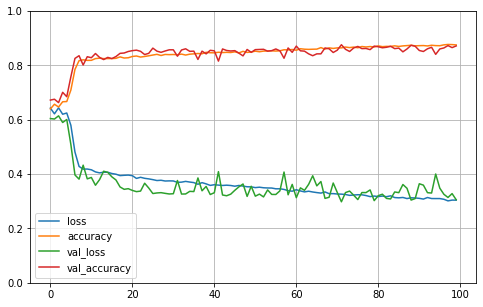

accuracy: 87.59%

1-way Cross Validation mean 87.59% (+/- 0.00%)
Done


In [13]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")